# Smart Retail Analytics - Open-Ended Data Mining Lab Project

## 1. Introduction & Dataset Description

This project analyzes the UCI Online Retail dataset to explore customer behavior and build predictive models. The dataset contains transactions with fields: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, and Country.

**Objectives:**
- Perform customer segmentation using clustering
- Discover product associations
- Predict high-value customers using classification models

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 2. Data Ingestion & Preprocessing

In [2]:
# Load the dataset
# Note: Update the path to your dataset location
df = pd.read_csv('Online_Retail.csv', encoding='unicode_escape')

# Display basic information
print("Dataset Shape:", df.shape)
print(df.columns.tolist())
df.head()

Dataset Shape: (541909, 8)
['ï»¿InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


,ï»¿InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print("\nPercentage of missing CustomerIDs:", 
      (df['CustomerID'].isnull().sum() / len(df)) * 100, "%")

Missing values per column:
ï»¿InvoiceNo         0
StockCode            0
Description       1454
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      135080
Country              0
dtype: int64

Percentage of missing CustomerIDs: 24.926694334288598 %


In [4]:
# Data cleaning
# Remove rows with missing CustomerID
df_clean = df.dropna(subset=['CustomerID']).copy()

# Remove cancelled transactions (InvoiceNo starting with 'C')
df_clean = df_clean[~df_clean['ï»¿InvoiceNo'].astype(str).str.startswith('C')]

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Remove rows with negative or zero quantities
df_clean = df_clean[df_clean['Quantity'] > 0]
df_clean = df_clean[df_clean['UnitPrice'] > 0]

print("Shape after cleaning:", df_clean.shape)
print("Percentage of data retained:", (len(df_clean) / len(df)) * 100, "%")

Shape after cleaning: (397884, 8)
Percentage of data retained: 73.42265952401603 %


In [5]:
# Feature Engineering
# Calculate TotalAmount
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Display summary statistics
print("Summary statistics for TotalAmount:")
print(df_clean['TotalAmount'].describe())

Summary statistics for TotalAmount:
count    397884.000000
mean         22.397000
std         309.071041
min           0.001000
25%           4.680000
50%          11.800000
75%          19.800000
max      168469.600000
Name: TotalAmount, dtype: float64


In [6]:
# Calculate RFM (Recency, Frequency, Monetary) features
# Set reference date as the latest date in the dataset + 1 day
reference_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID and calculate RFM
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'ï»¿InvoiceNo': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("RFM Features Shape:", rfm.shape)
print("\nRFM Statistics:")
rfm[['Recency', 'Frequency', 'Monetary']].describe()

RFM Features Shape: (4338, 4)

RFM Statistics:


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


In [7]:
# One-hot encode Country (for top 10 countries by transaction count)
top_countries = df_clean['Country'].value_counts().head(10).index.tolist()
df_clean['Country_Top10'] = df_clean['Country'].apply(
    lambda x: x if x in top_countries else 'Other'
)

# Create country features for RFM dataframe
customer_country = df_clean.groupby('CustomerID')['Country_Top10'].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Other'
).reset_index()

# Merge with RFM
rfm = rfm.merge(customer_country, on='CustomerID', how='left')

# One-hot encode
rfm_encoded = pd.get_dummies(rfm, columns=['Country_Top10'], prefix='Country')

print("Final preprocessed data shape:", rfm_encoded.shape)
rfm_encoded.head()

Final preprocessed data shape: (4338, 15)


,CustomerID,Recency,Frequency,Monetary,Country_Australia,Country_Belgium,Country_EIRE,Country_France,Country_Germany,Country_Netherlands,Country_Other,Country_Portugal,Country_Spain,Country_Switzerland,Country_United Kingdom
0,12346.0,326,1,77183.60,False,False,False,False,False,False,False,False,False,False,True
1,12347.0,2,7,4310.00,False,False,False,False,False,False,True,False,False,False,False
2,12348.0,75,4,1797.24,False,False,False,False,False,False,True,False,False,False,False
3,12349.0,19,1,1757.55,False,False,False,False,False,False,True,False,False,False,False
4,12350.0,310,1,334.40,False,False,False,False,False,False,True,False,False,False,False


## 3. Similarity & Dissimilarity Matrices

In [8]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# Standardize RFM features for distance calculation
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Sample 100 customers for visualization (full matrix would be too large)
sample_size = 100
sample_indices = np.random.choice(rfm_scaled.shape[0], sample_size, replace=False)
rfm_sample = rfm_scaled[sample_indices]
customer_ids_sample = rfm.iloc[sample_indices]['CustomerID'].values

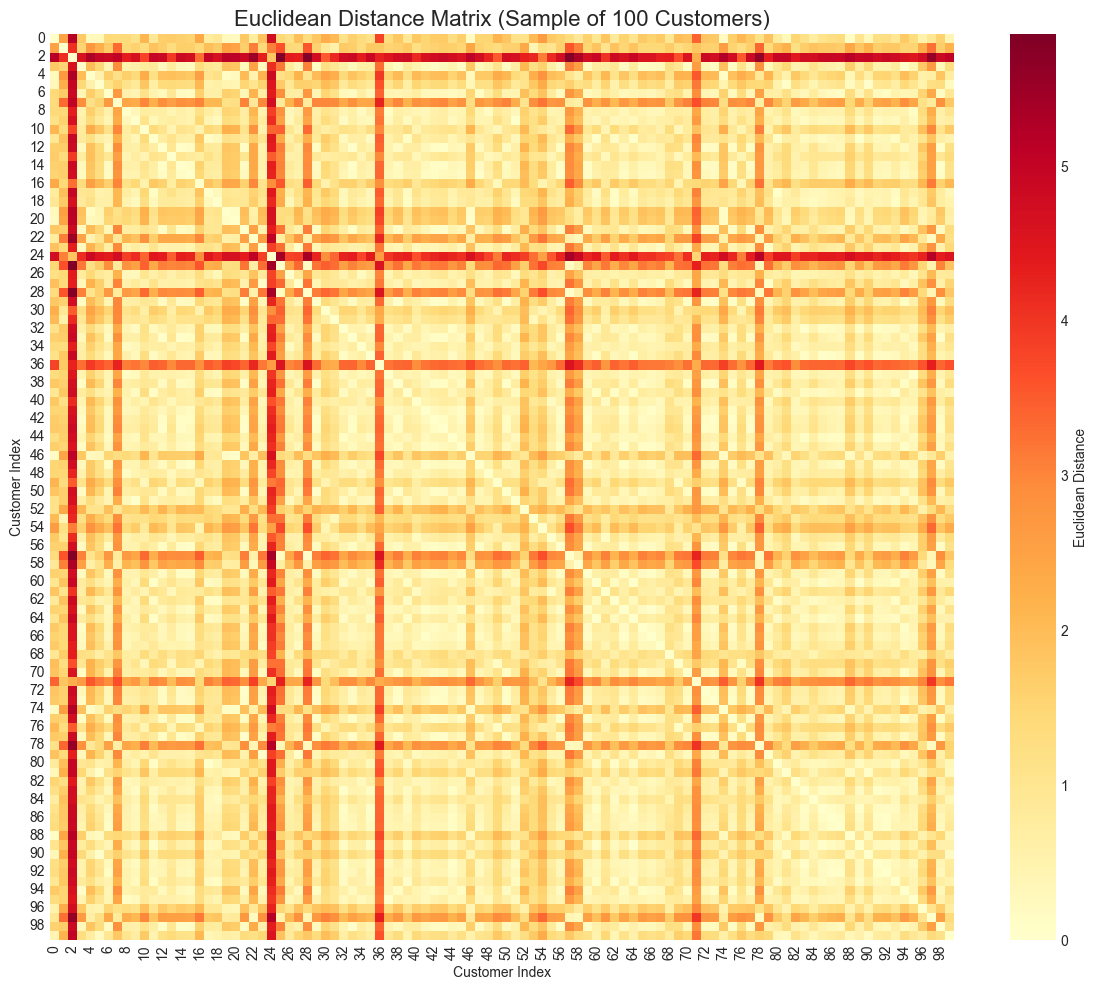

Distance matrix statistics:
Min distance: 0.02
Max distance: 5.85
Mean distance: 1.34


In [9]:
# Calculate Euclidean distance matrix
euclidean_dist = cdist(rfm_sample, rfm_sample, metric='euclidean')

# Visualize Euclidean distance heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(euclidean_dist, cmap='YlOrRd', cbar_kws={'label': 'Euclidean Distance'})
plt.title('Euclidean Distance Matrix (Sample of 100 Customers)', fontsize=16)
plt.xlabel('Customer Index')
plt.ylabel('Customer Index')
plt.tight_layout()
plt.show()

print("Distance matrix statistics:")
print(f"Min distance: {euclidean_dist[euclidean_dist > 0].min():.2f}")
print(f"Max distance: {euclidean_dist.max():.2f}")
print(f"Mean distance: {euclidean_dist[euclidean_dist > 0].mean():.2f}")

In [10]:
# Calculate Jaccard similarity based on top 10 purchased items
# Get top 10 items per customer
customer_items = df_clean.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().reset_index()
top_items_per_customer = customer_items.sort_values(['CustomerID', 'Quantity'], 
                                                    ascending=[True, False])
top_items_per_customer = top_items_per_customer.groupby('CustomerID').head(10)

# Create sets of top items for each customer
customer_item_sets = top_items_per_customer.groupby('CustomerID')['StockCode'].apply(set).to_dict()

In [11]:
# Calculate Jaccard similarity for sampled customers
jaccard_sim = np.zeros((sample_size, sample_size))

for i in range(sample_size):
    for j in range(sample_size):
        cust_i = customer_ids_sample[i]
        cust_j = customer_ids_sample[j]
        
        if cust_i in customer_item_sets and cust_j in customer_item_sets:
            set_i = customer_item_sets[cust_i]
            set_j = customer_item_sets[cust_j]
            
            if len(set_i.union(set_j)) > 0:
                jaccard_sim[i, j] = len(set_i.intersection(set_j)) / len(set_i.union(set_j))
            else:
                jaccard_sim[i, j] = 0
        else:
            jaccard_sim[i, j] = 0

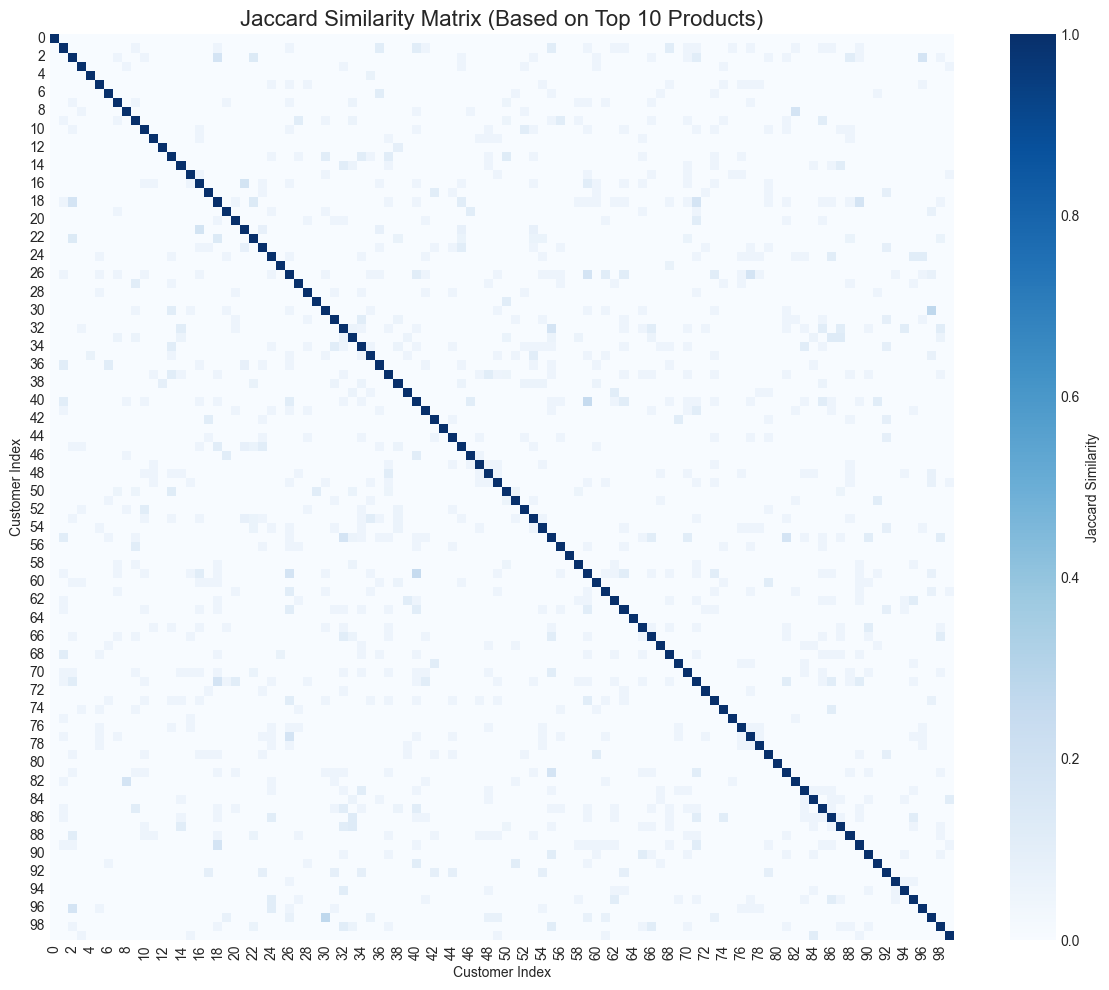

Jaccard similarity statistics:
Max similarity (excluding diagonal): 0.273
Mean similarity (excluding diagonal): 0.007
Percentage of zero similarities: 87.8%


In [12]:
# Visualize Jaccard similarity heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(jaccard_sim, cmap='Blues', cbar_kws={'label': 'Jaccard Similarity'})
plt.title('Jaccard Similarity Matrix (Based on Top 10 Products)', fontsize=16)
plt.xlabel('Customer Index')
plt.ylabel('Customer Index')
plt.tight_layout()
plt.show()

print("Jaccard similarity statistics:")
print(f"Max similarity (excluding diagonal): {jaccard_sim[jaccard_sim < 1].max():.3f}")
print(f"Mean similarity (excluding diagonal): {jaccard_sim[jaccard_sim < 1].mean():.3f}")
print(f"Percentage of zero similarities: {(jaccard_sim == 0).sum() / (sample_size**2) * 100:.1f}%")

## 4. Clustering

In [13]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Prepare data for clustering (using all RFM features)
X_clustering = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [14]:
# K-Means: Determine optimal K using elbow method and silhouette score
inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clustering)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering, kmeans.labels_))

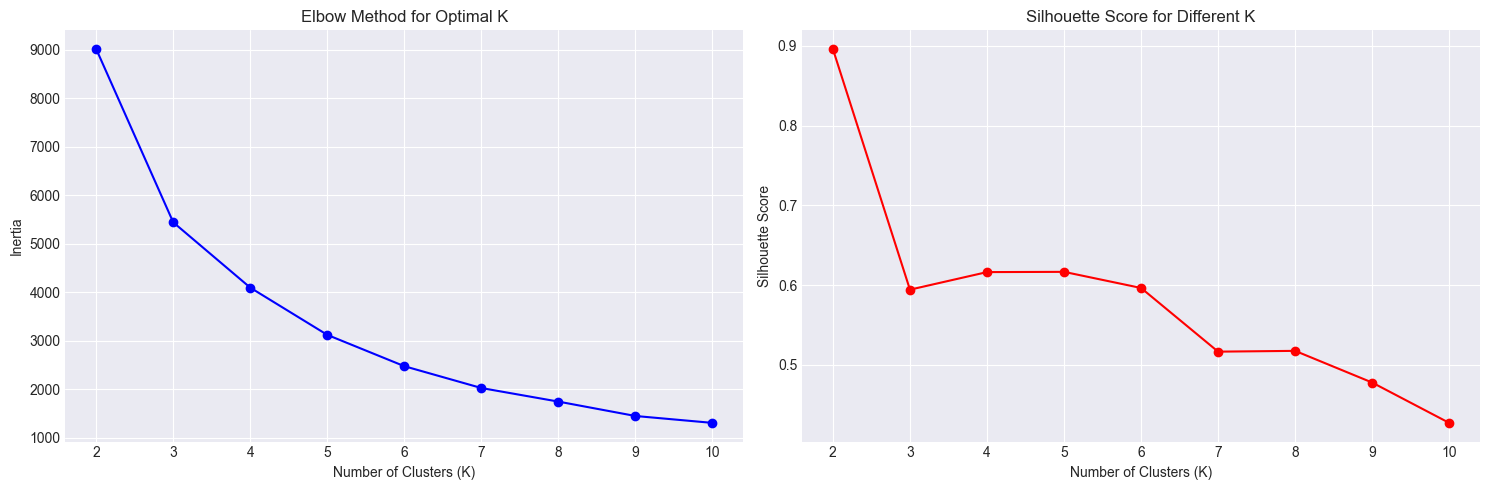

Optimal K based on silhouette score: 2


In [15]:
# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
ax1.plot(K, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True)

# Silhouette plot
ax2.plot(K, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Different K')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal K (highest silhouette score)
optimal_k = K[np.argmax(silhouette_scores)]
print(f"Optimal K based on silhouette score: {optimal_k}")

In [16]:
# Apply K-Means with optimal K
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_clustering)

# Apply PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_clustering)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

Explained variance ratio: [0.55502102 0.30249315]
Total explained variance: 85.75%


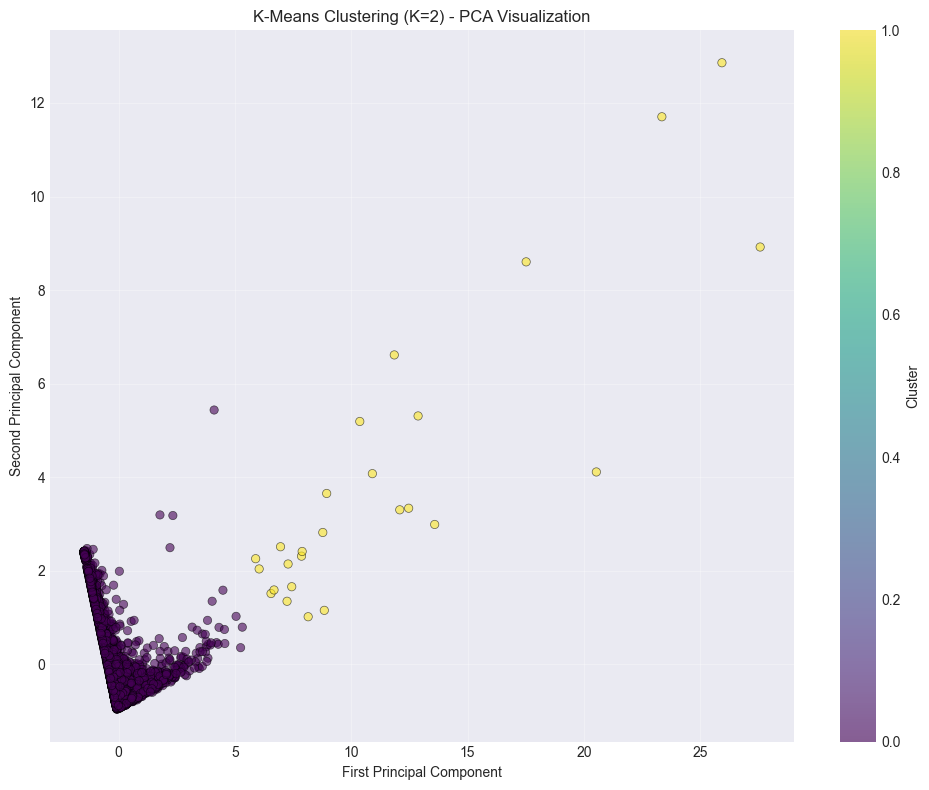


Cluster sizes:
Cluster 0: 4312 customers
Cluster 1: 26 customers


In [17]:
# Visualize K-Means clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                     cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'K-Means Clustering (K={optimal_k}) - PCA Visualization')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cluster statistics
print("\nCluster sizes:")
for i in range(optimal_k):
    print(f"Cluster {i}: {(kmeans_labels == i).sum()} customers")

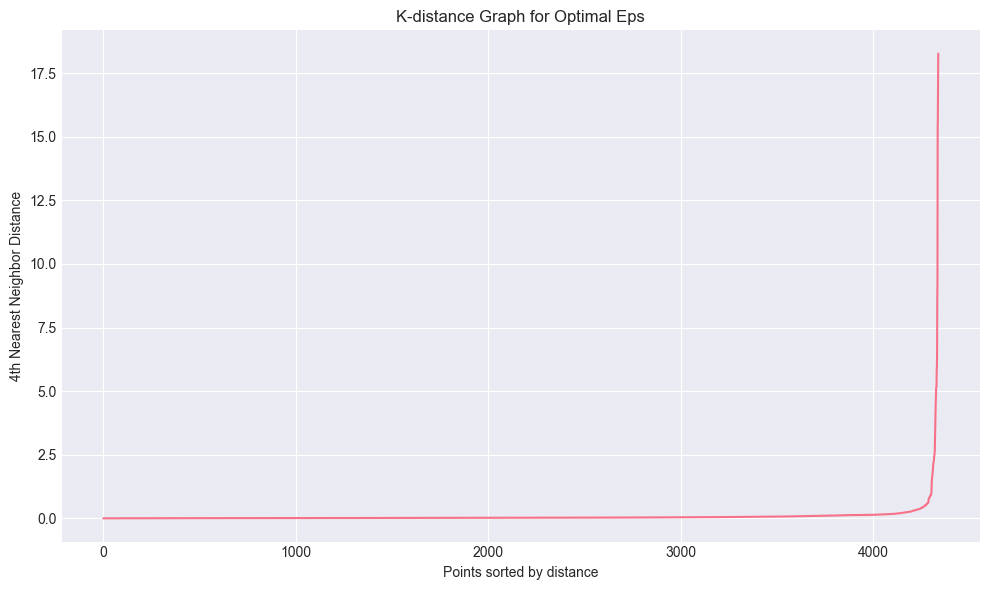

In [18]:
# DBSCAN clustering
# Determine optimal eps using k-distance graph
from sklearn.neighbors import NearestNeighbors

# Calculate k-distances (k=4 as min_samples will be 5)
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_clustering)
distances, indices = neighbors_fit.kneighbors(X_clustering)

# Sort distances
distances = np.sort(distances[:, 4], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.title('K-distance Graph for Optimal Eps')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Apply DBSCAN with tuned parameters
# Based on the k-distance plot, choose eps value at the "elbow"
eps = 0.5  # Adjust based on the k-distance plot
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_clustering)

# Count clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN Parameters: eps={eps}, min_samples={min_samples}")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")

DBSCAN Parameters: eps=0.5, min_samples=5
Number of clusters: 1
Number of noise points: 54 (1.2%)


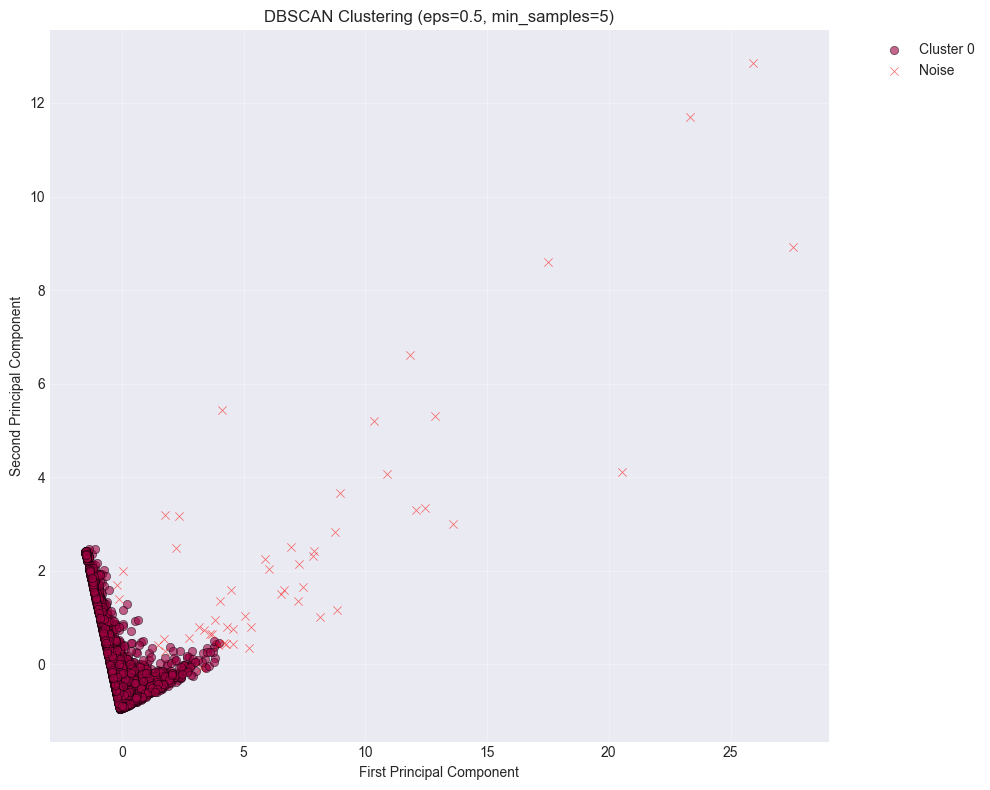

In [20]:
# Visualize DBSCAN clusters
plt.figure(figsize=(10, 8))

# Create custom colormap (noise points in red)
unique_labels = set(dbscan_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Noise points in red
        col = 'red'
        marker = 'x'
    else:
        marker = 'o'
    
    class_member_mask = (dbscan_labels == k)
    xy = X_pca[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, 
               label=f'Cluster {k}' if k != -1 else 'Noise',
               alpha=0.6, edgecolors='black', linewidth=0.5)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# Compare K-Means and DBSCAN
comparison_df = pd.DataFrame({
    'Algorithm': ['K-Means', 'DBSCAN'],
    'Number of Clusters': [optimal_k, n_clusters],
    'Noise Points': [0, n_noise],
    'Handles Outliers': ['No', 'Yes'],
    'Cluster Shape': ['Spherical', 'Arbitrary']
})

print("\n=== Clustering Algorithm Comparison ===")
print(comparison_df.to_string(index=False))

# Analyze cluster characteristics for K-Means
rfm['Cluster_KMeans'] = kmeans_labels
cluster_summary = rfm.groupby('Cluster_KMeans')[['Recency', 'Frequency', 'Monetary']].mean()
print("\n=== K-Means Cluster Characteristics (Mean Values) ===")
print(cluster_summary.round(2))


=== Clustering Algorithm Comparison ===
Algorithm  Number of Clusters  Noise Points Handles Outliers Cluster Shape
  K-Means                   2             0               No     Spherical
   DBSCAN                   1            54              Yes     Arbitrary

=== K-Means Cluster Characteristics (Mean Values) ===
                Recency  Frequency  Monetary
Cluster_KMeans                              
0                 93.06       3.90   1548.68
1                  6.04      66.42  85904.35


## 5. Association Rule Mining

In [22]:
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import time

# Prepare transaction data
# Group items by invoice
transactions = df_clean.groupby('ï»¿InvoiceNo')['StockCode'].apply(list).values.tolist()
print(f"Total number of transactions: {len(transactions)}")
print(f"Average items per transaction: {np.mean([len(t) for t in transactions]):.2f}")

Total number of transactions: 18532
Average items per transaction: 21.47


In [23]:
# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
print(f"Encoded dataframe shape: {df_encoded.shape}")

Encoded dataframe shape: (18532, 3665)


In [24]:
# Apply Apriori algorithm
print("Running Apriori algorithm...")
start_time = time.time()

# Find frequent itemsets with minimum support of 0.02
frequent_itemsets_apriori = apriori(df_encoded, min_support=0.02, use_colnames=True)
apriori_time = time.time() - start_time

print(f"Apriori completed in {apriori_time:.2f} seconds")
print(f"Number of frequent itemsets found: {len(frequent_itemsets_apriori)}")

Running Apriori algorithm...
Apriori completed in 2.11 seconds
Number of frequent itemsets found: 251


In [25]:
# Generate association rules from Apriori
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", 
                                 min_threshold=0.6)

# Filter rules with lift >= 1.2
rules_apriori = rules_apriori[rules_apriori['lift'] >= 1.2]

print(f"Number of rules (confidence >= 0.6, lift >= 1.2): {len(rules_apriori)}")

Number of rules (confidence >= 0.6, lift >= 1.2): 20


In [26]:
# Apply FP-Growth algorithm
print("\nRunning FP-Growth algorithm...")
start_time = time.time()

# Find frequent itemsets with FP-Growth
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=0.02, use_colnames=True)
fpgrowth_time = time.time() - start_time

print(f"FP-Growth completed in {fpgrowth_time:.2f} seconds")
print(f"Number of frequent itemsets found: {len(frequent_itemsets_fpgrowth)}")


Running FP-Growth algorithm...
FP-Growth completed in 2.54 seconds
Number of frequent itemsets found: 251


In [27]:
# Generate association rules from FP-Growth
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", 
                                  min_threshold=0.6)

# Filter rules with lift >= 1.2
rules_fpgrowth = rules_fpgrowth[rules_fpgrowth['lift'] >= 1.2]

print(f"Number of rules (confidence >= 0.6, lift >= 1.2): {len(rules_fpgrowth)}")

Number of rules (confidence >= 0.6, lift >= 1.2): 20


In [28]:
# Display top 10 rules by lift (from Apriori)
top_rules = rules_apriori.sort_values('lift', ascending=False).head(10)

# Format for display
display_rules = top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()
display_rules['antecedents'] = display_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
display_rules['consequents'] = display_rules['consequents'].apply(lambda x: ', '.join(list(x)))

print("\n=== Top 10 Association Rules by Lift ===")
print(display_rules.to_string(index=False))


=== Top 10 Association Rules by Lift ===
 antecedents  consequents  support  confidence      lift
       22698 22699, 22697 0.021045    0.701439 24.027846
22699, 22697        22698 0.021045    0.720887 24.027846
22699, 22698        22697 0.021045    0.894495 23.989564
       22698        22697 0.024822    0.827338 22.188466
       22697        22698 0.024822    0.665702 22.188466
22697, 22698        22699 0.021045    0.847826 20.066300
       22698        22699 0.023527    0.784173 18.559754
       22699        22697 0.029193    0.690932 18.530185
       22697        22699 0.029193    0.782923 18.530185
       22630        22629 0.022879    0.688312 18.119023



=== Algorithm Runtime Comparison ===
Algorithm  Runtime (seconds)  Frequent Itemsets  Rules Generated
  Apriori           2.105369                251               20
FP-Growth           2.539129                251               20


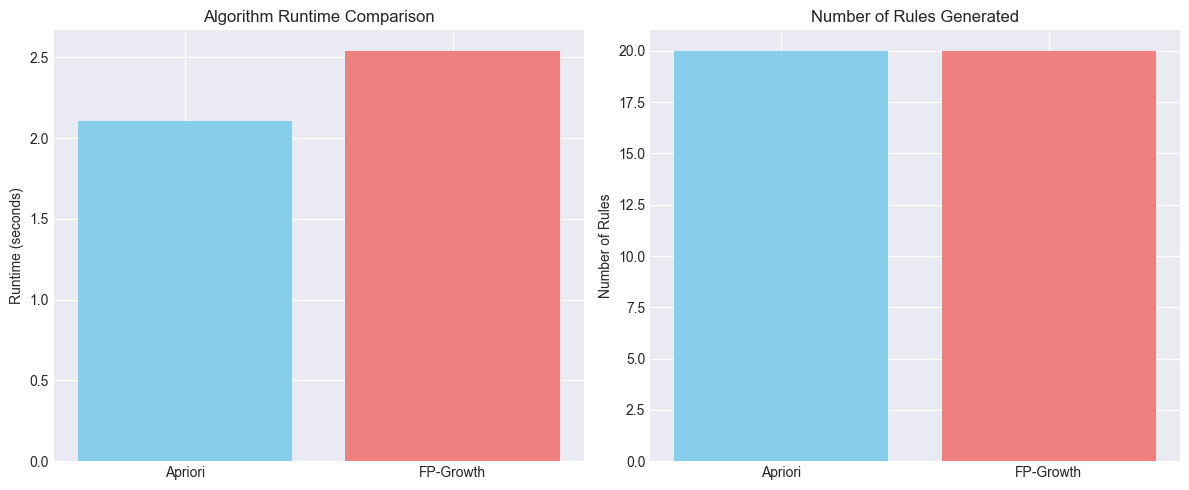

In [29]:
# Runtime comparison
runtime_comparison = pd.DataFrame({
    'Algorithm': ['Apriori', 'FP-Growth'],
    'Runtime (seconds)': [apriori_time, fpgrowth_time],
    'Frequent Itemsets': [len(frequent_itemsets_apriori), len(frequent_itemsets_fpgrowth)],
    'Rules Generated': [len(rules_apriori), len(rules_fpgrowth)]
})

print("\n=== Algorithm Runtime Comparison ===")
print(runtime_comparison.to_string(index=False))

# Visualize runtime comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Runtime comparison
ax[0].bar(['Apriori', 'FP-Growth'], [apriori_time, fpgrowth_time], 
          color=['skyblue', 'lightcoral'])
ax[0].set_ylabel('Runtime (seconds)')
ax[0].set_title('Algorithm Runtime Comparison')

# Rules comparison
ax[1].bar(['Apriori', 'FP-Growth'], [len(rules_apriori), len(rules_fpgrowth)], 
          color=['skyblue', 'lightcoral'])
ax[1].set_ylabel('Number of Rules')
ax[1].set_title('Number of Rules Generated')

plt.tight_layout()
plt.show()

## 6. Naïve Bayes Classification

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Create target variable: High-Value customer (Monetary > 75th percentile)
monetary_75th = rfm['Monetary'].quantile(0.75)
rfm['HighValue'] = (rfm['Monetary'] > monetary_75th).astype(int)

print(f"75th percentile of Monetary value: {monetary_75th:.2f}")
print(f"Number of High-Value customers: {rfm['HighValue'].sum()} ({rfm['HighValue'].mean()*100:.1f}%)")

75th percentile of Monetary value: 1661.74
Number of High-Value customers: 1085 (25.0%)


In [31]:
# Prepare features for Gaussian Naive Bayes
X_rfm = rfm[['Recency', 'Frequency', 'Monetary']].values
y = rfm['HighValue'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_rfm, y, test_size=0.3, 
                                                    random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 3036
Test set size: 1302


In [32]:
# Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predictions
y_pred_gnb = gnb.predict(X_test)
y_prob_gnb = gnb.predict_proba(X_test)[:, 1]

# Evaluate
print("=== Gaussian Naive Bayes Results ===")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gnb, 
                          target_names=['Low-Value', 'High-Value']))

=== Gaussian Naive Bayes Results ===

Classification Report:
              precision    recall  f1-score   support

   Low-Value       0.96      0.99      0.98       976
  High-Value       0.98      0.87      0.92       326

    accuracy                           0.96      1302
   macro avg       0.97      0.93      0.95      1302
weighted avg       0.96      0.96      0.96      1302



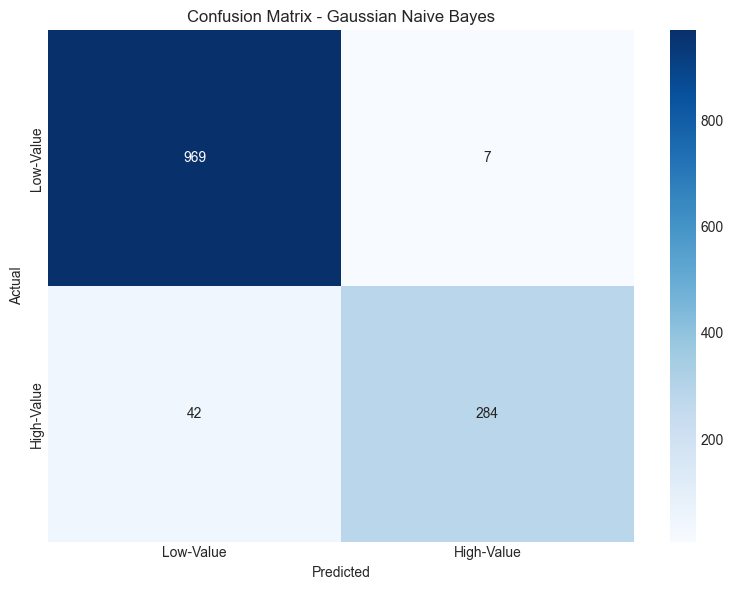

In [33]:
# Confusion Matrix for Gaussian NB
cm_gnb = confusion_matrix(y_test, y_pred_gnb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Low-Value', 'High-Value'])
plt.yticks([0.5, 1.5], ['Low-Value', 'High-Value'])
plt.tight_layout()
plt.show()

In [35]:
# Prepare features for Bernoulli Naive Bayes (binarized purchase flags)
# Create binary features for top 50 products
top_products = df_clean['StockCode'].value_counts().head(50).index.tolist()

customer_products = df_clean[df_clean['StockCode'].isin(top_products)].copy()

# If you have a 'Quantity' column and want to sum it
purchase_matrix = pd.crosstab(customer_products['CustomerID'], 
                             customer_products['StockCode'], 
                             values=customer_products['Quantity'],
                             aggfunc='sum')

# Fill NaN values with 0
purchase_matrix = purchase_matrix.fillna(0)

# Convert to binary
purchase_matrix = (purchase_matrix > 0).astype(int)

# Merge with target variable
purchase_matrix = purchase_matrix.merge(rfm[['CustomerID', 'HighValue']], 
                                       left_index=True, right_on='CustomerID')

print(f"Binary purchase matrix shape: {purchase_matrix.shape}")

Binary purchase matrix shape: (3767, 52)


In [36]:
# Prepare data for Bernoulli NB
X_binary = purchase_matrix.drop(['CustomerID', 'HighValue'], axis=1).values
y_binary = purchase_matrix['HighValue'].values

# Split data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

In [37]:
# Train Bernoulli Naive Bayes
bnb = BernoulliNB()
bnb.fit(X_train_bin, y_train_bin)

# Predictions
y_pred_bnb = bnb.predict(X_test_bin)
y_prob_bnb = bnb.predict_proba(X_test_bin)[:, 1]

# Evaluate
print("=== Bernoulli Naive Bayes Results ===")
print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred_bnb, 
                          target_names=['Low-Value', 'High-Value']))

=== Bernoulli Naive Bayes Results ===

Classification Report:
              precision    recall  f1-score   support

   Low-Value       0.84      0.91      0.87       814
  High-Value       0.70      0.57      0.63       317

    accuracy                           0.81      1131
   macro avg       0.77      0.74      0.75      1131
weighted avg       0.80      0.81      0.81      1131



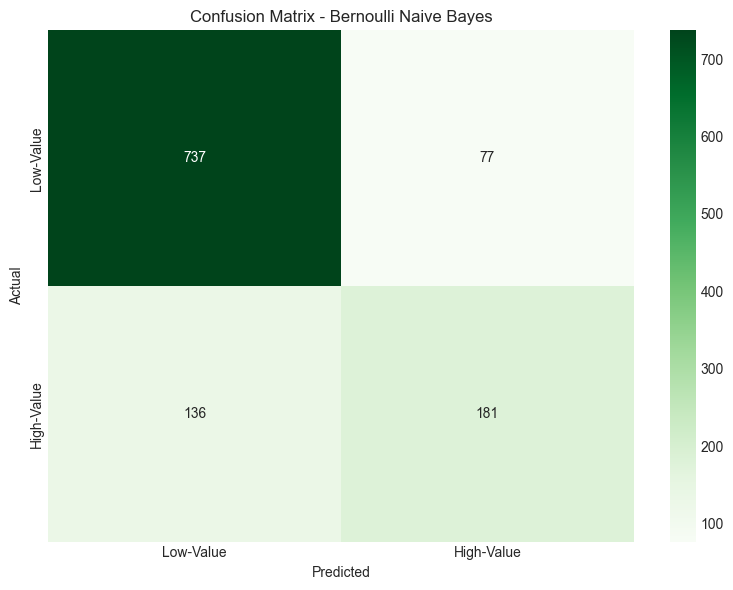

In [38]:
# Confusion Matrix for Bernoulli NB
cm_bnb = confusion_matrix(y_test_bin, y_pred_bnb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bnb, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Bernoulli Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Low-Value', 'High-Value'])
plt.yticks([0.5, 1.5], ['Low-Value', 'High-Value'])
plt.tight_layout()
plt.show()

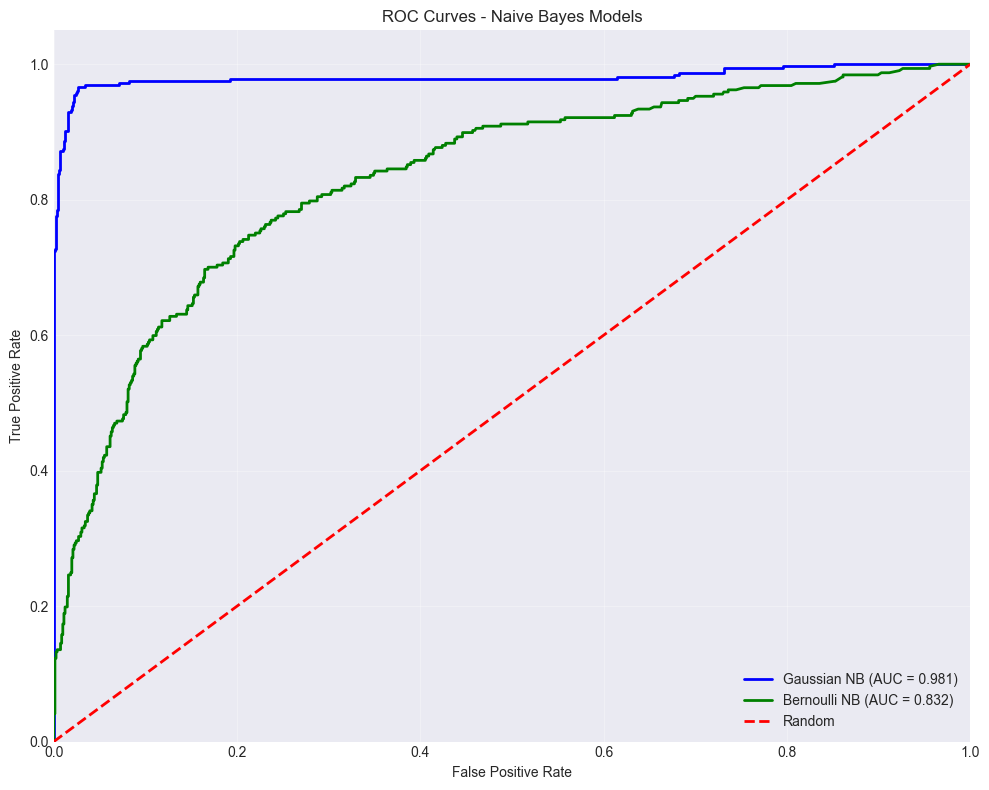

In [ ]:
# ROC Curves for both Naive Bayes models
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_prob_gnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

fpr_bnb, tpr_bnb, _ = roc_curve(y_test_bin, y_prob_bnb)
roc_auc_bnb = auc(fpr_bnb, tpr_bnb)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_gnb, tpr_gnb, color='blue', lw=2, 
         label=f'Gaussian NB (AUC = {roc_auc_gnb:.3f})')
plt.plot(fpr_bnb, tpr_bnb, color='green', lw=2, 
         label=f'Bernoulli NB (AUC = {roc_auc_bnb:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Naive Bayes Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Scale features for SVM
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train Linear SVM
print("Training Linear SVM...")
svm_linear = SVC(kernel='linear', probability=True, random_state=42)

# Grid search for C parameter
param_grid_linear = {'C': [0.1, 1, 10, 100]}
grid_linear = GridSearchCV(svm_linear, param_grid_linear, cv=5, scoring='accuracy')
grid_linear.fit(X_train_scaled, y_train)

print(f"Best parameters for Linear SVM: {grid_linear.best_params_}")
print(f"Best cross-validation score: {grid_linear.best_score_:.3f}")

Training Linear SVM...
Best parameters for Linear SVM: {'C': 100}
Best cross-validation score: 0.997


In [ ]:
# Evaluate Linear SVM
y_pred_linear = grid_linear.predict(X_test_scaled)
y_prob_linear = grid_linear.predict_proba(X_test_scaled)[:, 1]
accuracy_linear = accuracy_score(y_test, y_pred_linear)

print(f"\nLinear SVM Test Accuracy: {accuracy_linear:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_linear, 
                          target_names=['Low-Value', 'High-Value']))


Linear SVM Test Accuracy: 0.998

Classification Report:
              precision    recall  f1-score   support

   Low-Value       1.00      1.00      1.00       976
  High-Value       1.00      0.99      1.00       326

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302



In [ ]:
# Train RBF SVM
print("\nTraining RBF SVM...")
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)

# Grid search for C and gamma parameters
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}
grid_rbf = GridSearchCV(svm_rbf, param_grid_rbf, cv=5, scoring='accuracy')
grid_rbf.fit(X_train_scaled, y_train)

print(f"Best parameters for RBF SVM: {grid_rbf.best_params_}")
print(f"Best cross-validation score: {grid_rbf.best_score_:.3f}")


Training RBF SVM...
Best parameters for RBF SVM: {'C': 100, 'gamma': 0.1}
Best cross-validation score: 0.994


In [ ]:
# Evaluate RBF SVM
y_pred_rbf = grid_rbf.predict(X_test_scaled)
y_prob_rbf = grid_rbf.predict_proba(X_test_scaled)[:, 1]
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)

print(f"\nRBF SVM Test Accuracy: {accuracy_rbf:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rbf, 
                          target_names=['Low-Value', 'High-Value']))


RBF SVM Test Accuracy: 0.997

Classification Report:
              precision    recall  f1-score   support

   Low-Value       1.00      1.00      1.00       976
  High-Value       1.00      0.99      0.99       326

    accuracy                           1.00      1302
   macro avg       1.00      0.99      1.00      1302
weighted avg       1.00      1.00      1.00      1302



In [ ]:
# Visualize decision boundaries using PCA
# Apply PCA to reduce to 2D
pca_svm = PCA(n_components=2, random_state=42)
X_train_pca = pca_svm.fit_transform(X_train_scaled)
X_test_pca = pca_svm.transform(X_test_scaled)

# Retrain models on PCA features for visualization
svm_linear_pca = SVC(kernel='linear', C=grid_linear.best_params_['C'])
svm_linear_pca.fit(X_train_pca, y_train)

svm_rbf_pca = SVC(kernel='rbf', C=grid_rbf.best_params_['C'], 
                  gamma=grid_rbf.best_params_['gamma'])
svm_rbf_pca.fit(X_train_pca, y_train)

,C,100
,kernel,'rbf'
,degree,3
,gamma,0.1
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


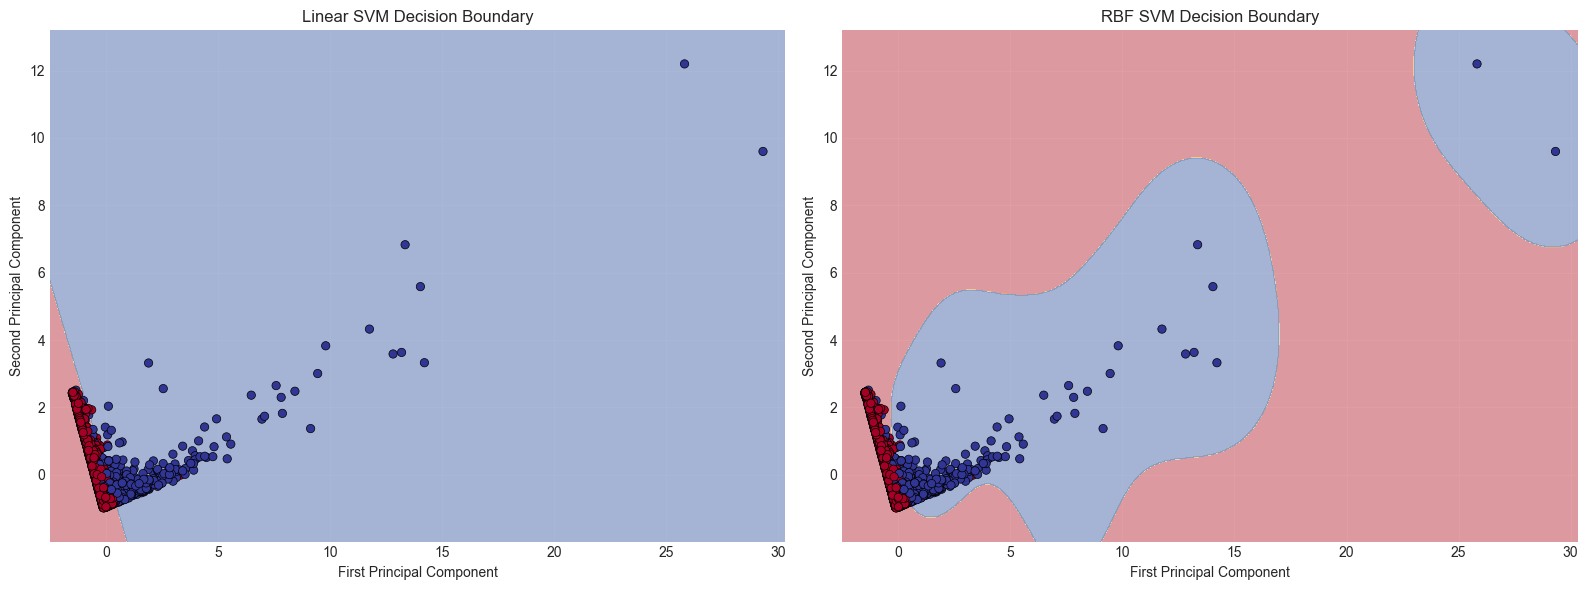

In [ ]:
# Create mesh for decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot decision boundaries
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for ax, model, title in [(ax1, svm_linear_pca, 'Linear SVM'),
                         (ax2, svm_rbf_pca, 'RBF SVM')]:
    # Plot decision boundary
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    
    # Plot training points
    scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, 
                        cmap='RdYlBu', edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title(f'{title} Decision Boundary')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Summary table of SVM results
svm_summary = pd.DataFrame({
    'Model': ['Linear SVM', 'RBF SVM'],
    'Best C': [grid_linear.best_params_['C'], grid_rbf.best_params_['C']],
    'Best Gamma': ['-', grid_rbf.best_params_['gamma']],
    'CV Score': [grid_linear.best_score_, grid_rbf.best_score_],
    'Test Accuracy': [accuracy_linear, accuracy_rbf]
})

print("\n=== SVM Model Comparison ===")
print(svm_summary.to_string(index=False))


=== SVM Model Comparison ===
     Model  Best C Best Gamma  CV Score  Test Accuracy
Linear SVM     100          -  0.997036       0.998464
   RBF SVM     100        0.1  0.994402       0.996928


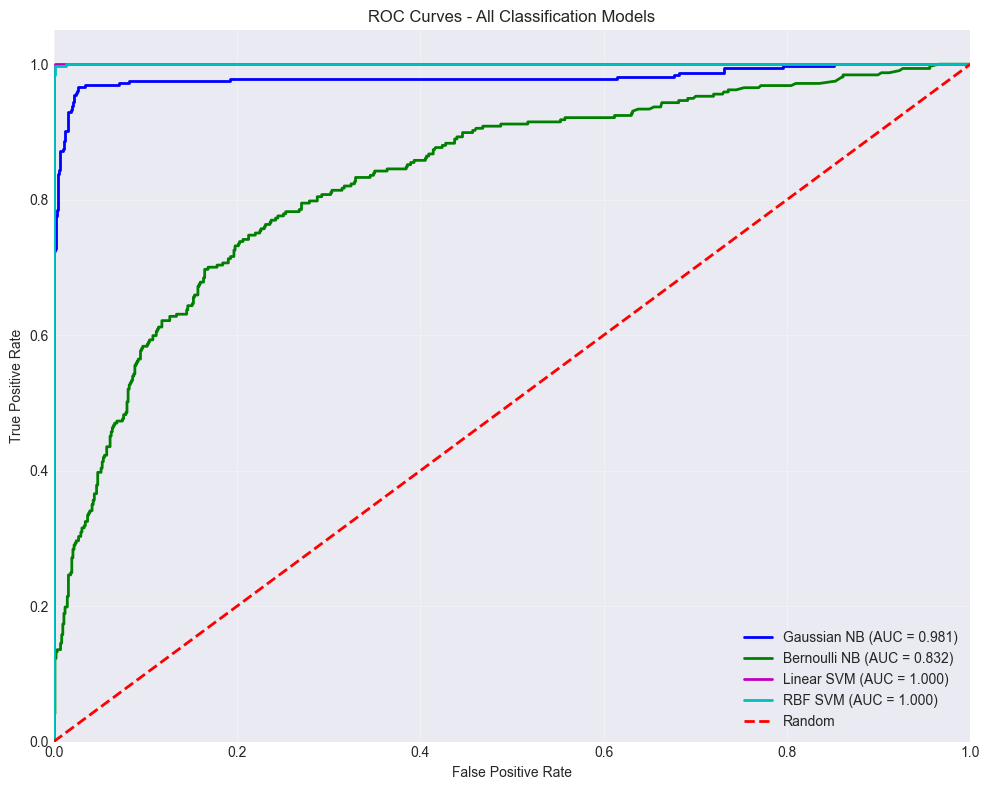

In [ ]:
# Compare all classification models with ROC curves
plt.figure(figsize=(10, 8))

# Calculate ROC for SVM models
fpr_linear, tpr_linear, _ = roc_curve(y_test, y_prob_linear)
roc_auc_linear = auc(fpr_linear, tpr_linear)

fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_prob_rbf)
roc_auc_rbf = auc(fpr_rbf, tpr_rbf)

# Plot all ROC curves
plt.plot(fpr_gnb, tpr_gnb, 'b-', lw=2, label=f'Gaussian NB (AUC = {roc_auc_gnb:.3f})')
plt.plot(fpr_bnb, tpr_bnb, 'g-', lw=2, label=f'Bernoulli NB (AUC = {roc_auc_bnb:.3f})')
plt.plot(fpr_linear, tpr_linear, 'm-', lw=2, label=f'Linear SVM (AUC = {roc_auc_linear:.3f})')
plt.plot(fpr_rbf, tpr_rbf, 'c-', lw=2, label=f'RBF SVM (AUC = {roc_auc_rbf:.3f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Classification Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Conclusions & Business Recommendations

### Key Findings:

1. **Customer Segmentation (Clustering)**:
   - K-Means identified distinct customer segments based on RFM values
   - DBSCAN successfully identified outliers and noise points, which could represent either VIP customers or problematic transactions
   - The optimal number of clusters helps in targeted marketing strategies

2. **Product Associations**:
   - Strong associations were found between certain product pairs
   - FP-Growth algorithm performed faster than Apriori while finding the same patterns
   - These associations can be used for product placement and cross-selling strategies

3. **Customer Value Prediction**:
   - SVM models (especially RBF kernel) showed the best performance in predicting high-value customers
   - Naive Bayes models provide interpretable results with reasonable accuracy
   - RFM features are strong predictors of customer value

### Business Recommendations:

1. **Targeted Marketing**:
   - Use the identified clusters to create personalized marketing campaigns
   - Focus retention efforts on high-value customers identified by the classification models

2. **Inventory Management**:
   - Stock frequently associated products together
   - Use association rules to optimize product placement in stores or websites

3. **Customer Lifetime Value**:
   - Implement the SVM model to identify potentially high-value customers early
   - Offer special promotions to customers predicted to become high-value

4. **Anomaly Detection**:
   - Monitor customers identified as noise points by DBSCAN for potential fraud or unusual behavior
   - VIP customers in the noise category might need special attention

5. **Cross-selling Opportunities**:
   - Implement recommendation systems based on the discovered association rules
   - Create bundle offers for products with high lift values